In [93]:
import pandas as pd
import geopandas as gpd
from statsmodels.formula.api import logit
taxi_zones = gpd.read_file("data/taxi_zones.shp")
taxi_zones = taxi_zones.to_crs(4326)
taxi_zones["lon"] = taxi_zones["geometry"].apply(lambda x: x.centroid.x)
taxi_zones["lat"] = taxi_zones["geometry"].apply(lambda x: x.centroid.y)
taxi_zones = taxi_zones[["zone", "LocationID", "borough", "lon", "lat"]]

In [150]:
cols = ["PULocationID", "DOLocationID", "hour_of_day", "day_of_week"]
uber_data = pd.read_csv("data/fhvhv_tripdata_2022-01.csv")
taxi_data = pd.read_csv("data/yellow_tripdata_2022-01.csv")

/var/folders/_m/zcfgmlf97j7gzvwfdnhyxytm0000gn/T/ipykernel_21822/2206519177.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data = pd.read_csv("data/yellow_tripdata_2022-01.csv")


In [151]:
uber_data = uber_data[uber_data["hvfhs_license_num"] == "HV0003"]
uber_data["day_of_week"] = uber_data["pickup_datetime"].astype("datetime64").dt.dayofweek
uber_data["hour_of_day"] = uber_data["pickup_datetime"].astype("datetime64").dt.hour
uber_data = uber_data[cols].reset_index()
# uber_data

In [152]:
taxi_data["day_of_week"] = taxi_data["tpep_pickup_datetime"].astype("datetime64").dt.dayofweek
taxi_data["hour_of_day"] = taxi_data["tpep_pickup_datetime"].astype("datetime64").dt.hour
taxi_data["duration"] = (taxi_data["tpep_dropoff_datetime"].astype("datetime64") - taxi_data["tpep_pickup_datetime"].astype("datetime64")).dt.total_seconds() / 60
taxi_cols = cols + ["duration", "total_amount"]
taxi_data = taxi_data[taxi_cols].reset_index()

In [153]:
taxi_agg = taxi_data.groupby(by=cols).agg({"total_amount": "mean", "duration": "mean", "index": "count"}).reset_index()
taxi_agg = taxi_agg.rename(columns={"index": "num_taxi_trips", "total_amount": "avg_amount", "duration": "avg_duration"})

In [154]:
uber_agg = uber_data.groupby(by=cols).count().reset_index()
uber_agg = uber_agg.rename(columns={"index": "num_uber_trips"})
uber_agg = uber_agg.merge(taxi_zones, left_on=["PULocationID"], right_on=["LocationID"])
uber_agg = uber_agg.rename(columns={"borough": "PUborough", "zone": "PUzone", "lon": "PUlon", "lat": "PUlat"})
uber_agg = uber_agg.merge(taxi_zones, left_on=["DOLocationID"], right_on=["LocationID"])
uber_agg = uber_agg.rename(columns={"borough": "DOborough", "zone": "DOzone", "lon": "DOlon", "lat": "DOlat"})

In [155]:
df = uber_agg.merge(taxi_agg, on=cols, how="inner")
df["prefer_uber"] = (df["num_uber_trips"] > df["num_taxi_trips"]).astype(int)

In [156]:
import geopy.distance
for i, r in df.iterrows():
    pu_coords = (df.loc[i, "PUlat"], df.loc[i, "PUlon"])
    do_coords = (df.loc[i, "DOlat"], df.loc[i, "DOlon"])
    df.loc[i, "distance"] = geopy.distance.geodesic(pu_coords, do_coords).miles

In [157]:
df = df[((df["num_uber_trips"] + df["num_taxi_trips"]) > 10) & (df["distance"] > 0)].copy()
df.to_csv("uber_vs_taxi.csv", index=False)

In [256]:
import numpy as np
df  = pd.read_csv("uber_vs_taxi.csv")
# df = df[(df["num_taxi_trips"] > 10) & (df["num_uber_trips"] > 10)].copy()
df["prefer_uber"] = (df["num_uber_trips"] > df["num_taxi_trips"]).astype(int)
df["avg_uber_amount"] = 0.71 * df["avg_duration"] + 1.55 * df["distance"] + 2.2
df.loc[df["avg_uber_amount"] < 10.2, "avg_uber_amount"] = 10.2 # minimum fare
df["price_diff"] = df["avg_amount"] - df["avg_uber_amount"]
df = df[df["price_diff"] < 25]
df = df[df["price_diff"] > -25]
for loc in df["PULocationID"].unique():
    if len(df[df["PULocationID"] == loc]) < 10:
        df = df[df["PULocationID"] != loc] 
for loc in df["DOLocationID"].unique():
    if len(df[df["DOLocationID"] == loc]) < 10:
        df = df[df["DOLocationID"] != loc] 
df = df[df["PUborough"] != "Staten Island"]
df = df[df["DOborough"] != "Staten Island"]
df.to_csv("logistic.csv", index=False)

In [257]:
# df.loc[(df["price_diff"] > 10), "prefer_uber"] = 1
# df.loc[(df["price_diff"] < -10), "prefer_uber"] = 0

In [261]:
import statsmodels.api as sm
df_train = df.sample(frac=0.7)
df_test = df.drop(df_train.index)
clf = logit(
    formula="prefer_uber ~ distance + price_diff + C(PULocationID) + C(hour_of_day) + C(day_of_week)",
    data=sm.add_constant(df)
).fit(method='bfgs')
clf.summary()

         Current function value: 0.467226
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            prefer_uber   No. Observations:               158531
Model:                          Logit   Df Residuals:                   158353
Method:                           MLE   Df Model:                          177
Date:                Mon, 02 May 2022   Pseudo R-squ.:                  0.2519
Time:                        19:06:32   Log-Likelihood:                -74070.
converged:                      False   LL-Null:                       -99017.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.0438      0.149      7.025      0.000       0.753       1.335
C(PULocationID)[T.7]       0.5932      0.194      3.051      0.002       0.212       0.974
C(PULocationID)[T.10]      0.0447      0.447      0.100      0.920      -0.830       0.920
C(PULocationID)[T.13]      0.9966      0.176      5.660      0.000       0.651       1.342
C(PULocationID)[T.14]      0.0049      1.343      0.004      0.997      -2.627       2.637
C(PULocationID)[T.17]      0.1229      0.297      0.414      0.679      -0.460       0.705
C(PULocationID)[T.18]      0.0229      0.622      0.037      0.971      -1.197       1.242
C(PULocationID)[T.22]      0.0087      0.989      0.009      0.993      -1.931       1.948
C(PULocationID)[T.24]     -0.2759      0.182     -1.519      0.129      -0.632       0.080
C(PULocationID)[T.25]      0.1856      0.258      0.719      0.472      -0.320       0.691
C(PULocationID)[T.26]      0.0108      0.877      0.012      0.990      -1.708       1.729
C(PULocationID)[T.33]      0.2150      0.245      0.878      0.380      -0.265       0.695
C(PULocationID)[T.35]      0.0623      0.389      0.160      0.873      -0.700       0.825
C(PULocationID)[T.36]      0.0295      0.591      0.050      0.960      -1.128       1.187
C(PULocationID)[T.37]      0.0871      0.355      0.246      0.806      -0.608       0.782
C(PULocationID)[T.39]      0.0432      0.469      0.092      0.927      -0.876       0.962
C(PULocationID)[T.40]      0.0652      0.379      0.172      0.863      -0.678       0.808
C(PULocationID)[T.41]      1.2519      0.177      7.090      0.000       0.906       1.598
C(PULocationID)[T.42]      0.8206      0.185      4.442      0.000       0.459       1.183
C(PULocationID)[T.43]     -2.5017      0.157    -15.938      0.000      -2.809      -2.194
C(PULocationID)[T.45]      0.1192      0.296      0.402      0.688      -0.462       0.700
C(PULocationID)[T.47]      0.0244      0.593      0.041      0.967      -1.138       1.187
C(PULocationID)[T.48]     -1.2244      0.145     -8.448      0.000      -1.508      -0.940
C(PULocationID)[T.49]      0.0984      0.324      0.303      0.762      -0.537       0.734
C(PULocationID)[T.50]      1.3089      0.165      7.934      0.000       0.986       1.632
C(PULocationID)[T.51]      0.0201      0.655      0.031      0.976      -1.263       1.303
C(PULocationID)[T.52]      0.0499      0.422      0.118      0.906      -0.776       0.876
C(PULocationID)[T.56]      0.0183      0.697      0.026      0.979      -1.347       1.384
C(PULocationID)[T.61]      0.1639      0.272      0.602      0.547      -0.369       0.697
C(PULocationID)[T.62]      0.0271      0.572      0.047      0.962      -1.094       1.148
C(PULocationID)[T.65]      0.1564      0.271      0.577      0.564      -0.375       0.687
C(PULocationID)[T.66]      0.0474      0.433      0.109      0.913      -0.801       0.896
C(PULocationID)[T.68]      0.3608      0.148      2.441 

In [237]:
def fpr(predictions, y_test):
    false_positives = sum(predictions & (1 - y_test))
    return false_positives / sum(1 - y_test)

def tpr(predictions, y_test):
    true_positives = sum(predictions & y_test)
    return true_positives / sum(y_test)

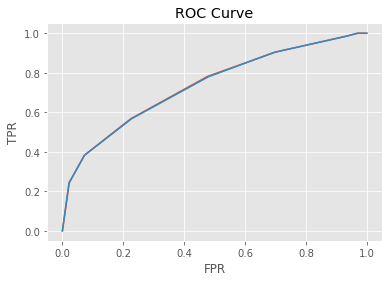

In [238]:
import matplotlib.pyplot as plt
def plot_ROC(df_predict, label):
    plt.style.use('ggplot')
    thresholds = np.linspace(0,1,11)
    fprs = []
    tprs = []
    for t in thresholds:
        predictions = clf.predict(df_predict) > t
        fprs.append(fpr(predictions, df_predict["prefer_uber"]))
        tprs.append(tpr(predictions, df_predict["prefer_uber"]))
    plt.plot(fprs, tprs, label=label)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve")
plot_ROC(df_train, label = "Training Set")
plot_ROC(df_test, label = "Test Set")

In [233]:
df["prefer_uber"].mean()

0.31350637600714015

In [240]:
df

,PULocationID,DOLocationID,hour_of_day,day_of_week,num_uber_trips,PUzone,LocationID_x,PUborough,PUlon,PUlat,...,DOborough,DOlon,DOlat,avg_amount,avg_duration,num_taxi_trips,prefer_uber,distance,avg_uber_amount,price_diff
0,11,14,12,2,11,Bath Beach,11,Brooklyn,-74.007488,40.604273,...,Brooklyn,-74.029892,40.624835,20.0000,11.366667,1,1,1.844142,13.128754,6.871246
1,11,14,15,0,12,Bath Beach,11,Brooklyn,-74.007488,40.604273,...,Brooklyn,-74.029892,40.624835,16.0000,37.300000,1,0,1.844142,31.541421,-15.541421
2,22,14,12,2,24,Bensonhurst West,22,Brooklyn,-73.995259,40.612218,...,Brooklyn,-74.029892,40.624835,16.0000,29.516667,1,0,2.018419,26.285383,-10.285383
3,22,14,13,5,33,Bensonhurst West,22,Brooklyn,-73.995259,40.612218,...,Brooklyn,-74.029892,40.624835,18.0000,27.816667,1,1,2.018419,25.078383,-7.078383
4,22,14,14,3,36,Bensonhurst West,22,Brooklyn,-73.995259,40.612218,...,Brooklyn,-74.029892,40.624835,19.5000,22.991667,2,1,2.018419,21.652633,-2.152633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163578,230,12,9,0,6,Times Sq/Theatre District,230,Manhattan,-73.984196,40.759818,...,Manhattan,-74.015564,40.702946,27.1760,20.756667,5,1,4.255700,23.533568,3.642432
163579,230,12,9,6,5,Times Sq/Theatre District,230,Manhattan,-73.984196,40.759818,...,Manhattan,-74.015564,40.702946,23.7475,19.785417,8,0,4.255700,22.843981,0.903519
163580,230,12,10,6,9,Times Sq/Theatre District,230,Manhattan,-73.984196,40.759818,...,Manhattan,-74.015564,40.702946,25.4925,20.347917,8,1,4.255700,23.243356,2.249144
163581,230,12,11,5,10,Times Sq/Theatre District,230,Manhattan,-73.984196,40.759818,...,Manhattan,-74.015564,40.702946,26.5150,22.745833,4,1,4.255700,24.945877,1.569123


In [241]:
uber_data = pd.read_csv("data/fhvhv_tripdata_2022-01.csv")
taxi_data = pd.read_csv("data/yellow_tripdata_2022-01.csv")

/var/folders/_m/zcfgmlf97j7gzvwfdnhyxytm0000gn/T/ipykernel_21822/753545456.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_data = pd.read_csv("data/yellow_tripdata_2022-01.csv")


In [245]:
uber_data = uber_data[uber_data["hvfhs_license_num"] == "HV0003"]
uber_data["day_of_week"] = uber_data["pickup_datetime"].astype("datetime64").dt.dayofweek
uber_data["hour_of_day"] = uber_data["pickup_datetime"].astype("datetime64").dt.hour
uber_data["duration"] = (uber_data["dropoff_datetime"].astype("datetime64") - uber_data["pickup_datetime"].astype("datetime64")).dt.total_seconds() / 60
uber_data["took_uber"] = 1
taxi_data["day_of_week"] = taxi_data["tpep_pickup_datetime"].astype("datetime64").dt.dayofweek
taxi_data["hour_of_day"] = taxi_data["tpep_pickup_datetime"].astype("datetime64").dt.hour
taxi_data["duration"] = (taxi_data["tpep_dropoff_datetime"].astype("datetime64") - taxi_data["tpep_pickup_datetime"].astype("datetime64")).dt.total_seconds() / 60
taxi_data["took_uber"] = 0

In [246]:
uber_data

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag,day_of_week,hour_of_day,duration,took_uber
0,HV0003,B03404,2022-01-01 00:07:24,2022-01-01 00:18:28,170,161,NaN,5,0,11.066667,1
1,HV0003,B03404,2022-01-01 00:22:32,2022-01-01 00:30:12,237,161,NaN,5,0,7.666667,1
2,HV0003,B03404,2022-01-01 00:57:37,2022-01-01 01:07:32,237,161,NaN,5,0,9.916667,1
3,HV0003,B03404,2022-01-01 00:18:02,2022-01-01 00:23:05,262,229,NaN,5,0,5.050000,1
4,HV0003,B03404,2022-01-01 00:28:01,2022-01-01 00:35:42,229,141,NaN,5,0,7.683333,1
...,...,...,...,...,...,...,...,...,...,...,...
14751586,HV0003,B03404,2022-01-31 23:27:20,2022-01-31 23:40:46,77,71,NaN,0,23,13.433333,1
14751587,HV0003,B03404,2022-01-31 23:45:46,2022-01-31 23:59:44,72,72,NaN,0,23,13.966667,1
14751588,HV0003,B03404,2022-01-31 23:03:25,2022-01-31 23:17:17,136,20,NaN,0,23,13.866667,1
14751589,HV0003,B03404,2022-01-31 23:20:26,2022-01-31 23:30:26,20,136,NaN,0,23,10.000000,1


In [247]:
taxi_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,day_of_week,hour_of_day,duration,took_uber
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0.5,3.65,0.0,0.3,21.95,2.5,5,0,17.816667,0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0.5,4.00,0.0,0.3,13.30,0.0,5,0,8.400000,0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0.5,1.76,0.0,0.3,10.56,0.0,5,0,8.966667,0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.5,0.00,0.0,0.3,11.80,2.5,5,0,10.033333,0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0.5,3.00,0.0,0.3,30.30,2.5,5,0,37.533333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,NaN,90,170,0,...,0.5,2.39,0.0,0.3,13.69,NaN,0,23,5.966667,0
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,NaN,107,75,0,...,0.5,4.35,0.0,0.3,24.45,NaN,0,23,10.650000,0
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,NaN,113,246,0,...,0.5,2.00,0.0,0.3,16.52,NaN,0,23,11.000000,0
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,NaN,148,164,0,...,0.5,0.00,0.0,0.3,15.70,NaN,0,23,12.050000,0


In [ ]:
pd.concat([])